Data Source: https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification

Process Source: https://www.youtube.com/watch?v=szyGiObZymo&list=PL-wATfeyAMNrtbkCNsLcpoAyBBRJZVlnf&index=12


In [1]:
import os
import librosa
import math
import json
import time

In [2]:
"""
@param dataset_path: relative location of the dataset.
@param json_path:
@param n_mfcc: number of mfcc variables to receive
@param hop_length: how far along to move the window
@param num_segments: how many parts to break each file into
"""
def create_mfcc_data(dataset_path, n_mfcc=13, n_fft=2048, hop_length=512, semanticLabelFolderLocation=-2,
              num_segments=5, sample_rate=20000,allLabels={"speech":1,"rap":2,"singing":3},duration = 3):
    #dictionary to store data
    # - mapping: mapp labels to values
    # - labels: target
    data={
        "mapping":[],
        "mfcc":[],
        "labels":[]
    }
    #the length of each sample, we know this for this dataset. Could be calculated dynamically
    
    samples_per_track = sample_rate * duration
    #how many data points we expect to appear in each segment we break our track into
    num_samples_per_segment = int(samples_per_track/num_segments)
    expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment/ hop_length)
    
    print ("num_samples_per_segment",num_samples_per_segment)
    #loop through all the genres
    #dirpath: folder we are currently in
    #dirnames: all the names of the subfolders
    #filenames: all the filenames
    #i: the count. It MUST be included
    #os.walk returns a generator, that creates a tuple of values: 
    #(current_path, directories in current_path, files in current_path).
    # - each iteration is a different genre
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        #ensure we're not yet at the dataset level
        if dirpath is not dataset_path:
            #save the semantic label (the mappings etc)
            #dirpath_components: the individual folder names that make up the full path
            dirpath_components = dirpath.split("\\") #genre/blues => ["genre","blues"]
            semantic_label = dirpath_components[semanticLabelFolderLocation]
            #use the parent directory of a sound file as its label
            data["mapping"].append(semantic_label)
            for f in filenames:
                # load audio file : the path of the file is just its directory path plus its name
                file_path = os.path.join(dirpath,f)
                signal, sr = librosa.load(file_path,sr=sample_rate)
                #process segments to extract MFCC and store data
                for s in range (0, num_segments):
                    start_sample = num_samples_per_segment * s
                    finish_sample = start_sample + num_samples_per_segment
                    #the mfcc for data points between start_sample and finish_sample
                    mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample],sr=sr,n_fft=n_fft,n_mfcc=n_mfcc, hop_length = hop_length)
                    mfcc=mfcc.T
                    #store mfcc for segement if it has the expected length
                    if len(mfcc)==expected_num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        # first iteration was the dataset path
                        correctLabel = allLabels[semantic_label]
                        data["labels"].append(correctLabel)
    return data

In [3]:
def save_mfcc_data(data,json_path):
    #save what we have created as a jason file
    with open(json_path,"w") as fp:
        json.dump(data,fp,indent=4)  

In [4]:
DATASET_PATH="./data"
JSON_PATH="data.json"
SAMPLE_RATE = 16000
N_MFCC = 13
N_FFT = 2048
HOP_LENGTH=512
NUM_SEGMENTS = 1
ALLLABELS={"speech":1,"rap":2,"singing":3}
DURATION = 3
SEMANTICLABELFOLDERLOCATION=-2

startTime = time.perf_counter()
data=create_mfcc_data(dataset_path=DATASET_PATH, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH, 
                      semanticLabelFolderLocation=SEMANTICLABELFOLDERLOCATION, num_segments=NUM_SEGMENTS, 
                      sample_rate=SAMPLE_RATE,allLabels=ALLLABELS,duration = DURATION)
save_mfcc_data(data,JSON_PATH)
endTime = time.perf_counter()

print ("Run Complete. Time taken:",endTime-startTime)

num_samples_per_segment 48000
Run Complete. Time taken: 11.113279200000001


The Network Itself
Source: https://www.youtube.com/watch?v=_xcFAiufwd0


In [5]:
import numpy as np
#load data

# split data into training and test

def load_data(dataset_path):
    with open(dataset_path, "r") as fp:
        data = json.load(fp)

        #convert lists into numpy arrays
        # x
        inputs=np.array(data["mfcc"])
        targets=np.array(data["labels"])
        return inputs,targets


In [6]:
inputs,targets = load_data("data.json")
#inputs.shape[0] num samples
#inputs.shape[1] num time readings
#inputs.shape[2] num values per time interval
print ("input shape", inputs.shape)

#normalise the data. @TODO not sure if this is necessary
mean = np.mean(inputs)
std = np.std(inputs)
inputs=(inputs-mean)/std

unique_elements, counts_elements = np.unique(targets, return_counts=True)
print("Frequency of unique values of the targets:")
print(np.asarray((unique_elements, counts_elements)))

input shape (1440, 94, 13)
Frequency of unique values of the targets:
[[  1   2   3]
 [480 480 480]]


In [7]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(inputs,targets,test_size=0.1)

print ("x_train",x_train.shape)
print ("x_test",x_test.shape)
print ("y_train",y_train.shape)
print ("y_test",y_test.shape)


x_train (1296, 94, 13)
x_test (144, 94, 13)
y_train (1296,)
y_test (144,)


In [8]:
from tensorflow import keras
#we will use only a traditional dense mlp for this first test, but CNNs would be far more accurate
#takes multidimensional input and treats it as a vector
#mfcc data is mfcc values taken at itervals. Second dimension is values for that interval.
flattenLayer = keras.layers.Flatten(input_shape=(inputs.shape[1],inputs.shape[2]))
#relu: activation function outputs 0 if net input is less than 0. else outputs h.
#relu is very very effective for training (much faster convergence)
# reduced probability of vanishing gradient: derivative of sigmoid can't be higher than 0,25 so it shrinks and becomes tiny
# relu does not have this problem. So relu allows us to have much deeper networks
#3 hidden layers
denseLayer1 = keras.layers.Dense(512,activation="relu")
denseLayer2 = keras.layers.Dense(256,activation="relu")
denseLayer3 = keras.layers.Dense(64,activation="relu")

#we have 10 categories
#softmax is an activation function that normalised the output (so total is 1)
outputLayer = keras.layers.Dense(10,activation="softmax")
model=keras.Sequential([flattenLayer,denseLayer1,denseLayer2,denseLayer3,outputLayer])


#Adam is a very very effecting sgd variant for deep learning
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
#put all the components together
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"]
              )
#describe our network
model.summary()






Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1222)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               626176    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 774,602
Trainable params: 774,602
Non-trainable params: 0
_________________________________________________________________



Dealing with overfitting

Source: https://www.youtube.com/watch?v=Gf5DO6br0ts&list=PL-wATfeyAMNrtbkCNsLcpoAyBBRJZVlnf&index=14

In [15]:
import matplotlib.pyplot as plt
def plot_history(history):
    fig,axs = plt.subplots(2)
    
    axs[0].plot(history.history["accuracy"],label="train accuracy")
    axs[0].plot(history.history["val_accuracy"],label="test accuracy")
    axs[0].set_ylabel("accuracy")
    #loc sets location
    axs[0].legend(loc="lower right")
    axs[0].set_title("accuracy eval")
    
    axs[1].plot(history.history["loss"],label="train error")
    axs[1].plot(history.history["val_loss"],label="test error")
    axs[1].set_ylabel("error")
    #loc sets location
    axs[1].legend(loc="upper right")
    axs[1].set_title("error eval")
    axs[1].set_xlabel("error")
    axs[1].set_xlabel("epoch")
    
    #just keeps the images from overlapping
    fig.tight_layout() 
    
    #plt.show()

In [16]:
#train the network
#batch-size usually 16-128 samples, quick, memory light and fairly accurate
#note the very higha ccuract of the test set and low accuracy of the training set (~98% vs ~58%)
# we are overfitting
#mode.fit returns "A History object. Its History.history attribute is a record of training loss values and metrics
#values at successive epochs, as well as validation loss values and validation metrics values (if applicable)"
history = model.fit(x_train, y_train, validation_data=(x_test, y_test),epochs=50, batch_size=32)

Epoch 1/50
41/41 [==============================] - 0s 3ms/step - loss: 6.9271e-04 - accuracy: 1.0000 - val_loss: 0.3260 - val_accuracy: 0.8958
Epoch 2/50
41/41 [==============================] - 0s 2ms/step - loss: 6.4425e-04 - accuracy: 1.0000 - val_loss: 0.3290 - val_accuracy: 0.8958
Epoch 3/50
41/41 [==============================] - 0s 2ms/step - loss: 6.0889e-04 - accuracy: 1.0000 - val_loss: 0.3267 - val_accuracy: 0.8889
Epoch 4/50
41/41 [==============================] - 0s 2ms/step - loss: 5.7170e-04 - accuracy: 1.0000 - val_loss: 0.3331 - val_accuracy: 0.8889
Epoch 5/50
41/41 [==============================] - 0s 2ms/step - loss: 5.3795e-04 - accuracy: 1.0000 - val_loss: 0.3282 - val_accuracy: 0.9028
Epoch 6/50
41/41 [==============================] - 0s 3ms/step - loss: 5.0531e-04 - accuracy: 1.0000 - val_loss: 0.3306 - val_accuracy: 0.9028
Epoch 7/50
41/41 [==============================] - 0s 2ms/step - loss: 4.7928e-04 - accuracy: 1.0000 - val_loss: 0.3341 - val_accuracy:

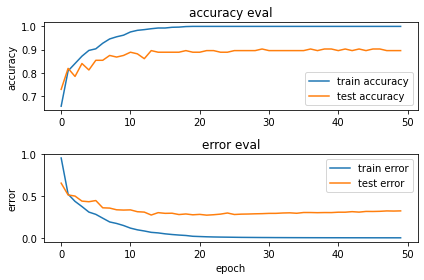

In [11]:
#notice that accuracy stops increasing for the test set pretty soon
# a sure sign of overfitting
plot_history(history)

<h2>Solutions to overfitting</h2>
<ul>
    <li>Simplify your architecture</li>
    <li> Audio data augmentation: increase number of training samples. Can artificially build training samples (e.g. with pitch shifting, background noise, and time stretching) -- only augment the TRAINING SET</li>
    <li> Early stopping: stop on conditions other than total num epochs</li>
    <li> Dropout: randomly (stochastically) drop neurons whilst training. 10% - 50% chance</li>
    <li> Regularisation: penalty to the error function. Punishes large weights. (L1 and L2 are commong types). L1: Appends absolute error to the standard error function. L2: squares each weights contribution to the standard error. (good for complex learning, but outliers are very bad)</li>
    
</ul>

In [12]:
#we will use only a traditional dense mlp for this first test, but CNNs would be far more accurate
#takes multidimensional input and treats it as a vector
#mfcc data is mfcc values taken at itervals. Second dimension is values for that interval.
flattenLayer = keras.layers.Flatten(input_shape=(inputs.shape[1],inputs.shape[2]))
#relu: activation function outputs 0 if net input is less than 0. else outputs h.
#relu is very very effective for training (much faster convergence)
# reduced probability of vanishing gradient: derivative of sigmoid can't be higher than 0,25 so it shrinks and becomes tiny
# relu does not have this problem. So relu allows us to have much deeper networks
#3 hidden layers
#IMPORTANT:: we are also adding REGULARIZER as well as dropout
denseLayer1 = keras.layers.Dense(512,activation="relu", kernel_regularizer=keras.regularizers.l2(0.0001))
#param is dropout probability
dropoutLayer1 = keras.layers.Dropout(0.3)
denseLayer2 = keras.layers.Dense(256,activation="relu",kernel_regularizer=keras.regularizers.l2(0.0001))
dropoutLayer2 = keras.layers.Dropout(0.3)
denseLayer3 = keras.layers.Dense(64,activation="relu",kernel_regularizer=keras.regularizers.l2(0.0001))
dropoutLayer3 = keras.layers.Dropout(0.3)
#we have 10 categories
#softmax is an activation function that normalised the output (so total is 1)
outputLayer = keras.layers.Dense(10,activation="softmax")
model_with_dropout=keras.Sequential([flattenLayer,denseLayer1,dropoutLayer1,denseLayer2,dropoutLayer2,
                                     denseLayer3,dropoutLayer3,outputLayer])

#Adam is a very very effecting sgd variant for deep learning
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
#put all the components together
model_with_dropout.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"]
              )
#describe our network
model_with_dropout.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1222)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               626176    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)               

In [13]:
history_with_dropout = model_with_dropout.fit(x_train, y_train, validation_data=(x_test, y_test),epochs=75, batch_size=32)

Epoch 1/75
41/41 [==============================] - 1s 6ms/step - loss: 1.7947 - accuracy: 0.3981 - val_loss: 1.0130 - val_accuracy: 0.6528
Epoch 2/75
41/41 [==============================] - 0s 3ms/step - loss: 1.1992 - accuracy: 0.5571 - val_loss: 0.8176 - val_accuracy: 0.7153
Epoch 3/75
41/41 [==============================] - 0s 3ms/step - loss: 1.0337 - accuracy: 0.6420 - val_loss: 0.7368 - val_accuracy: 0.7708
Epoch 4/75
41/41 [==============================] - 0s 3ms/step - loss: 0.9460 - accuracy: 0.6613 - val_loss: 0.6927 - val_accuracy: 0.7708
Epoch 5/75
41/41 [==============================] - 0s 3ms/step - loss: 0.8583 - accuracy: 0.6998 - val_loss: 0.6670 - val_accuracy: 0.7778
Epoch 6/75
41/41 [==============================] - 0s 3ms/step - loss: 0.7991 - accuracy: 0.7245 - val_loss: 0.6467 - val_accuracy: 0.7778
Epoch 7/75
41/41 [==============================] - 0s 3ms/step - loss: 0.7296 - accuracy: 0.7639 - val_loss: 0.6147 - val_accuracy: 0.8125
Epoch 8/75
41/41 [==

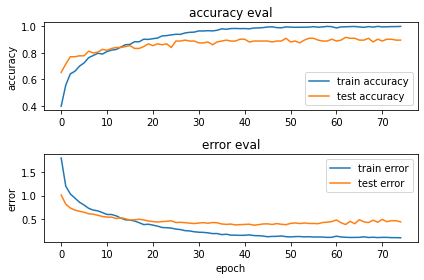

In [14]:
plot_history(history_with_dropout)

CNNS:
fewer parameters than desnse layers, perform better
underlying assumption: image and audio data are somehow structured
Relies on two special layers: convolution, pooling

convolution: applies the kernel to an image

shape of kernel determines what features it can extract

Architectural decisions CNN: grid size, stride, num kernels, depth (dimensions of the input)

CNN outputs as many 2ds arrays as the number of kernels for each conv layer

pooling: downsample an image. No parameters. Max pooling just takes the max over its grid and outputs that.

Flatten at the end for the final fully connected layer(s)

For audio data: we can just use the image of a spectrogram as input (treat audio as an image)

MFCCs for CNNs: 